# Installing and using pysmurf on your own machine

pysmurf is a public github repo and can be downloaded here - <a href="https://github.com/eyyoung24/pysmurf">https://github.com/eyyoung24/pysmurf</a>.  Fair warning - we're likely to move the repo soon.

pysmurf requires python3 and the pyepics package.  Installing python3 in Linux is straightforward (if it's not on your machine already).  I'm writing this on a Windows laptop where I have python3 installed via anaconda3 - I have the Python3.6 version installed from here - <a href="https://www.anaconda.com/distribution/#download-section">https://www.anaconda.com/distribution/#download-section</a>. We will be requiring Python 3.7 soon. 

You should be able to install pyepics using pip - find instructions on that here - <a href="http://cars9.uchicago.edu/software/python/pyepics3/installation.html">http://cars9.uchicago.edu/software/python/pyepics3/installation.html</a>.  The terminal command is;

If you're running anaconda on Windows you can just run that command on an anaconda prompt (type "anaconda prompt" in the search bar) to install pyepics.

Last, pysmurf doesn't yet have an installer, so you'll have to either add the directory its in to your PYTHONPATH, or add it in your python session.  Here's an example for how to add it to the path of a running python session (this is horrible, but I have to do it because I don't have admin privileges on my SLAC laptop):

In [4]:
import sys
# pysmurf on my machine is in C:\Users\shawn\Documents\GitHub\
sys.path.append('C:\\Users\\shawn\\Documents\\GitHub\\')
import pysmurf
print(pysmurf)

<module 'pysmurf' from '/usr/local/controls/Applications/smurf/pysmurf/pysmurf/__init__.py'>


If you're not on a SMuRF server, you'll need to instatiate pysmurf with a flag telling it not to try and talk to the EPICs server (and other things).  You'll also need to tell it where the cfg file the data was taken with is (as of right now - we need a better strategy for this).  Here's stupid way to find the path to your pysmurf's config file directory:

In [96]:
import os
pysmurf_cfg_file_dir=os.path.join(os.path.dirname(pysmurf.__file__),'cfg_files')
pysmurf_cfg_file_path=os.path.join(pysmurf_cfg_file_dir,'experiment_fp28_smurfsrv04.cfg')

print('pysmurf_cfg_file_dir=%s'%pysmurf_cfg_file_dir)
print('pysmurf_cfg_file_path=%s'%pysmurf_cfg_file_path)
os.path.exists(pysmurf_cfg_file_path)

pysmurf_cfg_file_dir=C:\Users\shawn\Documents\GitHub\pysmurf\cfg_files
pysmurf_cfg_file_path=C:\Users\shawn\Documents\GitHub\pysmurf\cfg_files\experiment_fp28_smurfsrv04.cfg


True

After running the above, you can instantiate an offline pysmurf instance using that cfg file via

In [100]:
S=pysmurf.SmurfControl(make_logfile=False, setup=False, offline=True, epics_root='test_epics', \
                      cfg_file=pysmurf_cfg_file_path)

[ 2019-01-31 11:57:26 ]  Offline mode


IndexError: index -1 is out of bounds for axis 0 with size 0

# SMuRF data

This tutorial shows how to open and interpret a lot of the most common data structures and files that get saved in routine SMuRF operation.  Almost all data is timestamped with the ctime at which the data was taken.  You can get the current ctime through SMuRF like this; 

## Time stream data

### How the data was taken

On smurf-srv04.  For this example, I have 410 resonators locked and tracking all together on bands 2 and 3.  Taking a 60 second time stream:

In [5]:
# Load pysmurf
import pysmurf

# Initialize a pysmurf instance connected to the EPICs server named 'test_epics'.  
# Do not run setup (assumes setup was run before this script).  Also assumes you're 
# fully tuned.
S = pysmurf.SmurfControl(make_logfile=False, setup=False, epics_root='test_epics', \
                         cfg_file='/usr/local/controls/Applications/smurf/pysmurf/pysmurf/cfg_files/experiment_fp28_smurfsrv04.cfg')

# Stream data to file for 60 seconds
datadir = S.take_stream_data(meas_time=60)

[ 2019-01-31 09:50:35 ]  Starting to take data.
[ 2019-01-31 09:50:36 ]  Writing PyRogue configuration to file : /data/smurf_data/20190131/1548957035/outputs/1548957036.yml
[ 2019-01-31 09:50:47 ]  Writing to file : /data/smurf_data/20190131/1548957035/outputs/1548957036.dat
[ 2019-01-31 09:50:50 ]  Band 2
[ 2019-01-31 09:50:50 ]  Band 3
[ 2019-01-31 09:50:50 ]  Generating gcp mask file. 215 channels added
[ 2019-01-31 09:50:50 ]  Reading SMuRF to GCP config file
[ 2019-01-31 09:50:50 ]  Reading SMuRF to GCP config file
[ 2019-01-31 09:50:51 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:TimingHeader:userConfig[0] 2
[ 2019-01-31 09:51:51 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:TimingHeader:userConfig[0] 6
[ 2019-01-31 09:51:51 ]  Done taking data.


After initializing a pysmurf instance, we streamed data to file for 60 seconds.  This generated three files in /data/smurf_data/20190130/1548916176/outputs/; 

In [6]:
ls /data/smurf_data/20190130/1548916176/outputs/1548916177*

/data/smurf_data/20190130/1548916176/outputs/1548916177.dat
/data/smurf_data/20190130/1548916176/outputs/1548916177_mask.txt
/data/smurf_data/20190130/1548916176/outputs/1548916177.yml


The .yml file is a record of every PyROGUE register value just before the data was taken.  This allows the configuration of different datasets to be compared register by register:

In [7]:
!head -n 200 /data/smurf_data/20190130/1548916176/outputs/1548916177.yml


AMCc:
  enable: 'True'
  ForceWrite: 'False'
  streamDataWriter:
    enable: 'True'
    dataFile: /data/smurf_data/20190130/1548915790/outputs/1548916090.dat
    open: 'False'
    bufferSize: '0'
    maxFileSize: '0'
  streamingInterface:
    enable: 'True'
    dataFile: ''
    open: 'False'
    bufferSize: '0'
    maxFileSize: '0'
  FpgaTopLevel:
    enable: 'True'
    AmcCarrierCore:
      enable: 'True'
      AxiVersion:
        enable: 'True'
        ScratchPad: '0x000000'
        FpgaReloadHalt: '0x0'
        FpgaReloadAddress: '0x0'
        UserReset: '0x0'
      AxiSysMonUltraScale:
        enable: 'True'
        GIER: '0x0'
        IPIER: '0x0'
        Configuration[0]: '0x0'
        Configuration[1]: '0x21df'
        Configuration[2]: '0x9b00'
        Configuration[3]: '0xf'
        SequenceReg8: '0x0'
        SequenceReg9: '0x0'
        SequenceReg_7_0[0]: '0x4f01'
        SequenceReg_7_0[1]: '0x0'
        SequenceReg_7_0[2]: '0x4f00'
        SequenceReg_7_0[3]: '0x0'
       

Unsurprisingly, it's a ton of info.  Just showing the first 200 lines above.

The *_mask.txt file is a record of which SMuRF channels were assigned to what array indices in the SMuRF .dat file.

In [8]:
!nl -v0 /data/smurf_data/20190130/1548916176/outputs/1548916177_mask.txt

     0	1024
     1	1025
     2	1026
     3	1027
     4	1028
     5	1029
     6	1030
     7	1032
     8	1033
     9	1034
    10	1036
    11	1037
    12	1040
    13	1041
    14	1042
    15	1043
    16	1044
    17	1045
    18	1046
    19	1048
    20	1049
    21	1052
    22	1054
    23	1056
    24	1057
    25	1058
    26	1059
    27	1060
    28	1062
    29	1064
    30	1065
    31	1066
    32	1068
    33	1069
    34	1070
    35	1072
    36	1074
    37	1075
    38	1076
    39	1077
    40	1078
    41	1080
    42	1081
    43	1084
    44	1086
    45	1088
    46	1089
    47	1090
    48	1091
    49	1094
    50	1097
    51	1098
    52	1100
    53	1101
    54	1102
    55	1104
    56	1106
    57	1107
    58	1109
    59	1112
    60	1113
    61	1118
    62	1120
    63	1139
    64	1150
    65	1153
    66	1154
    67	1157
    68	1159
    69	1161
    70	1162
    71	1163
    72	1165
    73	1167
    74	1169
    75	1170
    76	1171
    77	1173
    78	1174
    79	1175
    80	1177
    81	1178
    82	1179
    

Here I've just printed the contents of the mask file with a line number, indexed from zero.  For the existing SMuRF stream transmitter, we can only write 512 channels to file simultaneously.  Each SMuRF 500 MHz band has 512 "CryoChannel" instances, each of which can be configured to track a resonator (otherwise it's just not used).  This mask file encodes the mapping from those channels onto the 512 we're able to save (right now - this will be expanded for SO).  The actual master mask used by the data writer lives somewhere else, but a copy is saved with each dataset so that the mapping is not lost when/if the master changes.  The master mask file lives in the transmitter directory here - /usr/local/controls/Applications/smurf/smurf2mce/master/mcetransmit/mask.txt.  pysmurf knows how to modify it as needed to write the channels you have configured to file - but you have to have a copy of the mask to figure out how to back out which channel ended up at what index in the array saved on disk.

Lastly, the .dat file is data.

Now we will load the data. The data and mask are assumed to have the same file name, so we will only pass it the datafile. It returns time, data, and the mask.

In [10]:
t, dat, mask = S.read_stream_data(datadir)

[ 2019-01-31 09:53:08 ]  Treating data as GCP file
[ 2019-01-31 09:53:08 ]  Reading /data/smurf_data/20190131/1548957035/outputs/1548957036.dat


The mask is shape (n_band, n_channel) and is -1 for all unassigned channels and is the array index for the assigned channels. So if mask[2,15] = 4, then band 2 channel 15 is the 4th element (0 indexed) in the datafile.

In [13]:
import numpy as np
np.shape(mask)

(4, 512)

In [16]:
band, channel = np.where(mask != -1)
print(band)
print(channel)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[  1   2   6   9  13  16  18  19  20  21  25  30  34  35  40  41  45  46
  52  56  57  64  65  73  83  88  96 115 126 129 130 133 139 147 149 150
 153 154 155 157 158 162 165 167 171 179 182 186 187 203 205 209 217 218
 226 238 250 256 257 259 260 261 264 266 269 275 277 280 281 282 284 286
 288 290 293 297 298 305 306 308 312 313 316 323 336 338 340 341 345 349
 357 390 394 395 399 401 402 403 406 409 410 422 427 430 439 442 445 455
 465 470 478   6   8  12  16  18  20  26  30  38  50  52  58  62  70  84
  94  96 102 129 130 131 135 137 139 141 143 149 155

Let us arbitrarily choose a channel and plot it.

In [21]:
idx = 10
print('Band {} Ch {:03}'.format(band[idx], channel[idx]))
print(mask[band[idx],channel[idx]])

Band 2 Ch 025
10


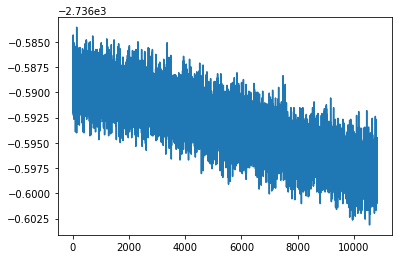

In [22]:
import matplotlib.pyplot as plt
plt.plot(dat[mask[band[idx], channel[idx]]])

## Tracking setup data

## IV data 